# Hyperparameter Tuning using HyperDrive

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [82]:
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Environment
from azureml.core import ScriptRunConfig
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive import BayesianParameterSampling
from azureml.train.hyperdrive import uniform, choice
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails
import azureml.core
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
%matplotlib inline
display.mpl_style ='ggplot'
pd.set_option('use_inf_as_na', True)
print("SDK version:", azureml.core.VERSION)

SDK version: 1.22.0


## Notebook setup

In [83]:
ws = Workspace.from_config()
ws = Workspace.from_config()
experiment_name = 'camels-exp'
project_folder = './dmik'
experiment=Experiment(ws, experiment_name)

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: my_ws
Azure region: eastus
Subscription id: 0c66ad45-500d-48af-80d3-0039ebf1975e
Resource group: final-rgp


In [84]:
cluster_name = "my-cmp"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

Found existing compute target


## Dataset

The primary objective was to develop an early warning system, i.e. binary classification of failed ('Target'==1) vs. survived ('Target'==0), for the US banks using their quarterly filings with the regulator. Overall, 137 failed banks and 6,877 surviving banks were used in this machine learning exercise. Historical observations from the first 4 quarters ending 2010Q3 (stored in ./data) are used to tune the model and out-of-sample testing is performed on quarterly data starting from 2010Q4 (stored in ./oos). 

In [ ]:
dataset = ws.datasets['camels11'] 
df = dataset.to_pandas_dataframe()
len(df)

In [ ]:
df.loc[df['Target']==0].count()

## Hyperdrive configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

### Perform one test run first

Test run the script that will be used for traing

In [25]:
!python dmik/train.py

Attempted to log scalar metric Learning rate::
0.1
Attempted to log scalar metric Number of estimators::
20
Attempted to log scalar metric Number of features::
5
Attempted to log scalar metric Max tree depth::
2
Attempted to log scalar metric norm_macro_recall:
0.68571


Install required packages

In [26]:
env = Environment('sklearn-env')
cd = CondaDependencies.create(
    pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'],
    conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd
env.register(workspace = ws)


{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210104.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "sklearn-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"


Create the estimator

In [30]:
args = ['--learning_rate', 0.1, '--n_estimators', 20, '--max_features', 5,  '--max_depth', 2]
src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

Submit just 1 run for now and view the results with RunDetails

In [31]:
run = experiment.submit(src)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [32]:
run.get_metrics()

{'Learning rate:': 0.1,
 'Number of estimators:': 20,
 'Number of features:': 5,
 'Max tree depth:': 2,
 'norm_macro_recall': 0.68571}

### Complete `Hyperdrive` configureation and start the `Run`

Create the different params that you will be using during training, no policy Bayesian sampling.

In [33]:
param_sampling = BayesianParameterSampling( {
        "learning_rate": choice(0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95),
        "n_estimators" : choice(20, 30, 40, 50),
        "max_features": choice(2, 3, 4, 5),
        "max_depth" : choice(2, 3, 4, 5)
        }
)

Specify the primary metric - 'recall' is warranted to minimize classification Type II 

In [34]:
primary_metric_name="norm_macro_recall"
primary_metric_goal=PrimaryMetricGoal.MAXIMIZE

Create the hyperdrive config

In [35]:
hd_config = HyperDriveConfig(run_config=src,
                             hyperparameter_sampling=param_sampling,
                             policy=None,
                             primary_metric_name=primary_metric_name,
                             primary_metric_goal=primary_metric_goal,
                             max_total_runs=80,
                             max_concurrent_runs=2)

Start the HyperDrive run

In [36]:
hyperdrive_run = experiment.submit(hd_config)

## Run details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [37]:
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [38]:
assert(hyperdrive_run.get_status() == "Completed")

## Best model

Get the best model from the hyperdrive experiments and display all the properties of the model.

In [ ]:
#best_run, fitted_model = hyperdrive_run.get_output() #this is from automl may not work

In [39]:
print(hyperdrive_run.get_best_run_by_primary_metric())

Run(Experiment: camels-exp,
Id: HD_b85e15b9-deb1-460a-a8a9-9fa125f1c233_25,
Type: azureml.scriptrun,
Status: Completed)


Get the best run from all HyperDrive runs

In [40]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['arguments']
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
camels-exp,HD_b85e15b9-deb1-460a-a8a9-9fa125f1c233_25,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [41]:
best_run_metrics

{'Learning rate:': 0.1,
 'Number of estimators:': 20,
 'Number of features:': 3,
 'Max tree depth:': 2,
 'norm_macro_recall': 0.74286}

In [43]:
print(best_run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_8580477fd38875d7f9560f3ece7260cd0b728987301b003ec10012dc14de6d79_d.txt', 'azureml-logs/65_job_prep-tvmps_8580477fd38875d7f9560f3ece7260cd0b728987301b003ec10012dc14de6d79_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_8580477fd38875d7f9560f3ece7260cd0b728987301b003ec10012dc14de6d79_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/104_azureml.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'outputs/model.joblib']


In [ ]:
# # Save the best model on folders './models'
# import os
# os.makedirs('./models', exist_ok=True)
# best_run.download_file('/outputs/model.pkl', os.path.join('./models', 'hyperdr_model.pkl'))

In [ ]:
#joblib.dump(value=fitted_model, filename="hyperdr_model.joblib")

In [ ]:
# # Register the best model
# model = best_run.register_model(model_name = 'hyperdr_model',
# model_path='./outputs/hyperdr_model.pkl')
# model

## Out-of-sample testing

Load the model

In [46]:
hyperdr_model = joblib.load('outputs/model.joblib')

Define periods from which new , 'unseen' data will be used. In this case 9 out-of-sample quarters of reports that the model has never seen.

In [47]:
oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4']

Reproduce the scaler and train-test-split with `random_state=123`

In [50]:
path = 'https://raw.githubusercontent.com/allaccountstaken/automl_v_hyperdrive/main/data/camel_data_after2010Q3.csv'
df = pd.read_csv(path, index_col=0)
df.dropna(inplace=True)
X = df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
y = df['Target'].values.reshape(-1, 1)    
    # Perorm train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), train_size=0.7, random_state=123)

    # Additionally consider scalling (this may not be important for tree-based models)
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Get the date for the quarter, get features and true y_oos, send features to the web service and get response, y_pred. Use y_oos and y_pred to compute confusion matrix. Store results in a dictionary.

In [61]:
outofsample_results = {}
for report in oos_reports:
    # Get the quarter-end report and drop missing values
    path = 'https://raw.githubusercontent.com/allaccountstaken/automl_v_hyperdrive/main/oos/camel_data_after{}_OOS.csv'.format(report)
    oos_df = pd.read_csv(path, index_col=0)
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    # Assing true values (y_oos) and features (X_oos)
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos)
    y_pred = hyperdr_model.predict(X_oos_scaled)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_oos, y_pred).ravel()
    mcc = np.round(matthews_corrcoef(y_oos, y_pred), 2)
    
    # Build report as a dictionary 
    outofsample_results[report] = {'Actually failed':fn+tp, 
                                   'Predicted fail':tp,
                                   'Recall (TP/TP+FN)':np.round(tp/(tp+fn), 2),
                                   'Precision (TP/TP+FP)':np.round(tp/(tp+fp), 2),
                                   'Matthews Correlation':mcc
                                  }

In [62]:
outofsample_results

{'2010Q4': {'Actually failed': 24,
  'Predicted fail': 20,
  'Recall (TP/TP+FN)': 0.83,
  'Precision (TP/TP+FP)': 0.53,
  'Matthews Correlation': 0.66},
 '2011Q1': {'Actually failed': 19,
  'Predicted fail': 19,
  'Recall (TP/TP+FN)': 1.0,
  'Precision (TP/TP+FP)': 0.23,
  'Matthews Correlation': 0.48},
 '2011Q2': {'Actually failed': 25,
  'Predicted fail': 19,
  'Recall (TP/TP+FN)': 0.76,
  'Precision (TP/TP+FP)': 0.28,
  'Matthews Correlation': 0.45},
 '2011Q3': {'Actually failed': 18,
  'Predicted fail': 16,
  'Recall (TP/TP+FN)': 0.89,
  'Precision (TP/TP+FP)': 0.27,
  'Matthews Correlation': 0.48},
 '2011Q4': {'Actually failed': 13,
  'Predicted fail': 13,
  'Recall (TP/TP+FN)': 1.0,
  'Precision (TP/TP+FP)': 0.23,
  'Matthews Correlation': 0.48},
 '2012Q1': {'Actually failed': 15,
  'Predicted fail': 14,
  'Recall (TP/TP+FN)': 0.93,
  'Precision (TP/TP+FP)': 0.19,
  'Matthews Correlation': 0.42},
 '2012Q2': {'Actually failed': 12,
  'Predicted fail': 11,
  'Recall (TP/TP+FN)': 0.

These are summary data used in model training. This is needed for the plot only.

In [63]:
insample_results = {
    '2009Q4':{'Actually failed':31, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q1':{'Actually failed':35, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q2':{'Actually failed':41, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}, 
    '2010Q3':{'Actually failed':30, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}}

results_df = pd.DataFrame.from_dict(insample_results, orient='index')
results_df

,Actually failed,Predicted fail,Recall (TP/TP+FN),Precision (TP/TP+FP)
2009Q4,31,0,0.69,0.63
2010Q1,35,0,0.69,0.63
2010Q2,41,0,0.69,0.63
2010Q3,30,0,0.69,0.63


Create a plot: counts of banks that actually failed (blue) and counts of banks that are predicted to fail (orange) as vertical bars. Area curves represent recall scores and precision. Note: the objective is to maximize recal, i.e. make the orange bars equal to the blue bars.

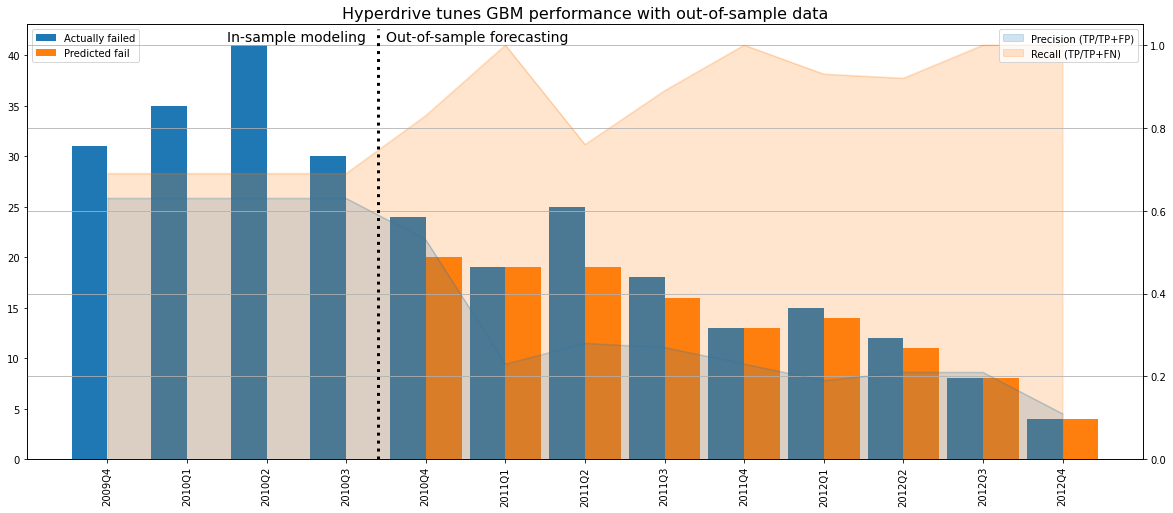

In [64]:
# Combine all metrics in one DataFrame
results_plot_df = results_df.append(pd.DataFrame.from_dict(outofsample_results).T, sort=True)

# Prepare figure and split axis
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()

# Plot bars and areas
results_plot_df[['Actually failed','Predicted fail']].plot(
    kind='bar', ax=ax1, width=0.9).legend(loc='upper left')                                                              
results_plot_df[['Precision (TP/TP+FP)', 'Recall (TP/TP+FN)']].plot(
    kind='area', stacked=False, alpha=0.2, ax=ax2).legend(loc='upper right')
plt.axvline(x=3.4, ymin=0, ymax = 0.99, linewidth=3, color='k', linestyle=':')

# Plot managements comtrols
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.grid(True)
ax1.set_xlim([-1.01, 13.01])

# Assign titles
ax1.text(x= 1.5, y=42.5, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.5, y=42.5, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
plt.title('Hyperdrive tunes GBM performance with out-of-sample data', fontsize=16)

plt.show()

# Save the model in ONNX format

In [67]:
initial_type = [('float_input', FloatTensorType([None, 4]))]
#covert to ONNX
onx = convert_sklearn(hyperdr_model, initial_types=initial_type)
#save to file
with open("hdr_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.


-- end --